# Import libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [29]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, classification_report
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder, MinMaxScaler,RobustScaler,MaxAbsScaler
from sklearn.compose import ColumnTransformer
from  sklearn.pipeline  import  Pipeline
from  sklearn  import  set_config
set_config(display='diagram')

In [30]:
from sklearn.linear_model import LogisticRegression

# Custom functions

In [31]:
def dataset_parameters(df,target):
    df_features = df.drop([target], axis=1)
    data_type_numerical = ['int64', 'float64']
    data_type_object = ['object', 'bool', 'category']
    data_type_date = ['datetime64']
    categorical_features  = list(filter(lambda x: df_features[x].dtype in data_type_object, df_features.columns))
    numerical_features = list(filter(lambda x: df_features[x].dtype in data_type_numerical, df_features.columns))
    date_features = list(filter(lambda x: df_features[x].dtype in data_type_date, df_features.columns))
    all_features  = numerical_features  + categorical_features + date_features 
    return categorical_features, numerical_features, date_features, all_features,target 

In [32]:
def accuracy_performance(model, X, y):
    accuracy = round(model.score(X,y),3)
    return pd.DataFrame({'pipeline':[str(model)], 'accuracy':[accuracy]})

In [33]:
def classification_analysis(df):
    df['pipeline'] = df['pipeline'].apply(lambda x: x.split('(')[0])
    
    fig = plt.figure(figsize=(6, 4))
    sns.barplot(x='pipeline', y='accuracy', data=df)
    plt.ylim(0, 1)
    plt.xlabel('')
    plt.ylabel('accuracy', fontsize=10)
    plt.xticks(rotation=60, fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', linewidth=0.8)

    plt.show()
    return df

In [34]:
def classificator_performance(model, X_test, y_test, target_names):
    y_pred = model.predict(X_test)
    return print(classification_report(y_test, y_pred, target_names=target_names)) 

In [35]:
def classificator_analysis(model, X_test, y_test, labels_name):
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    y_pred_proba = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    labels = list(labels_name.values())
    swapped_dict = {v: k for k, v in labels_name.items()}
    y_test = y_test.map(swapped_dict)
    y_pred = pd.Series(y_pred).map(swapped_dict)

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, cmap='Blues', annot=True, xticklabels=labels, yticklabels=labels, ax=axs[0])
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('True')

    # Plot ROC curve
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(model.classes_.shape[0]):
        fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        sns.lineplot(x=fpr[i], y=tpr[i], label='ROC curve (class {0}) (AUC = {1:0.2f})'.format(labels_name[i], roc_auc[i]), linewidth=1.5, ax=axs[1])
    
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')
    axs[1].legend(loc="lower right")

    # Plot Precision-Recall curve
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(model.classes_.shape[0]):
        precision[i], recall[i], _ = precision_recall_curve(y_test == i, y_pred_proba[:, i])
        average_precision[i] = average_precision_score(y_test == i, y_pred_proba[:, i])
        sns.lineplot(x=recall[i], y=precision[i], label='Precision-recall curve (class {0}) (AP = {1:0.2f})'.format(labels_name[i], average_precision[i]), linewidth=1.5, ax=axs[2])
    
    axs[2].set_xlim([0.0, 1.0])
    axs[2].set_ylim([0.0, 1.05])
    axs[2].set_xlabel('Recall')
    axs[2].set_ylabel('Precision')
    axs[2].legend(loc="lower left")

    return plt.show()

# Loading data

In [36]:
with open('penguins_species_classes.pkl', 'rb') as f:
    target_classes = pickle.load(f)

In [37]:
target_classes

{0: 'Adelie', 1: 'Chinstrap', 2: 'Gentoo'}

In [38]:
with open('penguins_df.pkl', 'rb') as f:
    df = pickle.load(f)

In [39]:
df

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,species
0,Torgersen,39.1,18.7,181.0,3750.0,MALE,Adelie
1,Torgersen,39.5,17.4,186.0,3800.0,FEMALE,Adelie
2,Torgersen,40.3,18.0,195.0,3250.0,FEMALE,Adelie
3,Torgersen,36.7,19.3,193.0,3450.0,FEMALE,Adelie
4,Torgersen,39.3,20.6,190.0,3650.0,MALE,Adelie
...,...,...,...,...,...,...,...
328,Biscoe,47.2,13.7,214.0,4925.0,FEMALE,Gentoo
329,Biscoe,46.8,14.3,215.0,4850.0,FEMALE,Gentoo
330,Biscoe,50.4,15.7,222.0,5750.0,MALE,Gentoo
331,Biscoe,45.2,14.8,212.0,5200.0,FEMALE,Gentoo


In [40]:
categorical_features, numerical_features, date_features, all_features, target = dataset_parameters(df,'species')

In [41]:
X = df[all_features]

In [42]:
y = df[target]

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13) 

# Setup pipeline

In [44]:
categorical_transformer = Pipeline(steps=[
    ('one' , OneHotEncoder())
])

In [45]:
numerical_transformer = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('normalize', Normalizer())
])

In [46]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

In [47]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression())
])

In [48]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler()),
                                                                  ('normalize',
                                                                   Normalizer())]),
                                                  ['culmen_length_mm',
                                                   'culmen_depth_mm',
                                                   'flipper_length_mm',
                                                   'body_mass_g']),
                                                 ('cat',
                                                  Pipeline(steps=[('one',
                                                                   OneHotEncoder())]),
                                                  ['island', 'sex'])])),
                ('model', LogisticRegression())])

# Setup and run grid search

In [49]:
params_space = {
    'preprocessor__num__scale': [StandardScaler(), MaxAbsScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    'preprocessor__num__normalize': [Normalizer(), 'passthrough'],
    #'model__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    #'model__C': [0.1, 0.5, 1, 5, 10],
    #'model__fit_intercept': [True, False],
    'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    #'model__max_iter': [100, 200, 300],
    #'model__tol': [1e-4, 1e-3, 1e-2, 1e-1],
    #'model__warm_start': [True, False],
    #'model__class_weight': [None, 'balanced']
}

In [50]:
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_macro',
    'recall': 'recall_macro',
    'f1': 'f1_macro'
}

In [51]:
grid = GridSearchCV(pipeline, param_grid=params_space, cv=5, scoring=scoring, refit="f1", verbose=1)

In [25]:
grid.fit(X_train,  y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/chicco/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/chicco/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler()),
                                                                                         ('normalize',
                                                                                          Normalizer())]),
                                                                         ['culmen_length_mm',
                                                                          'culmen_depth_mm',
                                                                          'flipper_length_mm',
                                                                          'body_mass_g']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('one',
                                                                                          OneHotEncoder())]),
                                                                         ['island',
                                                                          'sex'])])),
                                       ('model', LogisticRegression())]),
             param_grid={'preprocessor__num__normalize': [Normalizer(),
                                                          'passthrough'],
                         'preprocessor__num__scale': [StandardScaler(),
                                                      MaxAbsScaler(),
                                                      MinMaxScaler(),
                                                      RobustScaler(),
                                                      'passthrough']},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1_macro',
                      'precision': 'precision_macro',
                      'recall': 'recall_macro'},
             verbose=1)

In [26]:
grid.best_score_

0.9965721819380355

In [27]:
grid.best_params_

{'preprocessor__num__normalize': Normalizer(),
 'preprocessor__num__scale': MinMaxScaler()}

In [28]:
grid.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler()),
                                                                  ('normalize',
                                                                   Normalizer())]),
                                                  ['culmen_length_mm',
                                                   'culmen_depth_mm',
                                                   'flipper_length_mm',
                                                   'body_mass_g']),
                                                 ('cat',
                                                  Pipeline(steps=[('one',
                                                                   OneHotEncoder())]),
                                                  ['island', 'sex'])])),
                ('model', LogisticRegression(solver='newton-cg'))])

In [29]:
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_f1', ascending=True).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__solver,param_preprocessor__num__normalize,param_preprocessor__num__scale,params,split0_test_accuracy,split1_test_accuracy,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
12,0.027007,0.001280,0.008000,0.000073,lbfgs,Normalizer(),MinMaxScaler(),"{'model__solver': 'lbfgs', 'preprocessor__num_...",1.0,1.00,...,0.006349,1,1.0,1.000000,1.000000,0.982861,1.0,0.996572,0.006856,1
22,0.009194,0.000308,0.007965,0.000060,liblinear,Normalizer(),MinMaxScaler(),"{'model__solver': 'liblinear', 'preprocessor__...",1.0,1.00,...,0.006349,1,1.0,1.000000,1.000000,0.982861,1.0,0.996572,0.006856,1
2,0.027079,0.001208,0.008084,0.000061,newton-cg,Normalizer(),MinMaxScaler(),"{'model__solver': 'newton-cg', 'preprocessor__...",1.0,1.00,...,0.006349,1,1.0,1.000000,1.000000,0.982861,1.0,0.996572,0.006856,1
42,0.014794,0.000199,0.008879,0.000581,saga,Normalizer(),MinMaxScaler(),"{'model__solver': 'saga', 'preprocessor__num__...",1.0,1.00,...,0.006349,1,1.0,1.000000,1.000000,0.982861,1.0,0.996572,0.006856,1
32,0.012166,0.000412,0.008215,0.000204,sag,Normalizer(),MinMaxScaler(),"{'model__solver': 'sag', 'preprocessor__num__n...",1.0,1.00,...,0.006349,1,1.0,1.000000,1.000000,0.982861,1.0,0.996572,0.006856,1
19,0.050668,0.000763,0.007300,0.000762,lbfgs,passthrough,passthrough,"{'model__solver': 'lbfgs', 'preprocessor__num_...",1.0,1.00,...,0.012121,11,1.0,1.000000,0.976375,1.000000,1.0,0.995275,0.009450,6
29,0.007932,0.000058,0.007063,0.000163,liblinear,passthrough,passthrough,"{'model__solver': 'liblinear', 'preprocessor__...",1.0,1.00,...,0.012121,11,1.0,1.000000,0.976375,1.000000,1.0,0.995275,0.009450,6
17,0.027606,0.000913,0.008000,0.000094,lbfgs,passthrough,MinMaxScaler(),"{'model__solver': 'lbfgs', 'preprocessor__num_...",1.0,0.98,...,0.006349,1,1.0,0.975997,1.000000,1.000000,1.0,0.995199,0.009601,8
27,0.008277,0.000031,0.007700,0.000037,liblinear,passthrough,MinMaxScaler(),"{'model__solver': 'liblinear', 'preprocessor__...",1.0,0.98,...,0.006349,1,1.0,0.975997,1.000000,1.000000,1.0,0.995199,0.009601,8
7,0.028171,0.000816,0.008185,0.000295,newton-cg,passthrough,MinMaxScaler(),"{'model__solver': 'newton-cg', 'preprocessor__...",1.0,0.98,...,0.006349,1,1.0,0.975997,1.000000,1.000000,1.0,0.995199,0.009601,8


# Base vs Best pipeline

In [52]:
categorical_transformer_base = Pipeline(steps=[
    ('one' , OneHotEncoder())
])

In [53]:
numerical_transformer_base = Pipeline(steps=[
    ('scale', StandardScaler())
])

In [54]:
preprocessor_base = ColumnTransformer(transformers=[
    ('num', numerical_transformer_base, numerical_features),
    ('cat', categorical_transformer_base, categorical_features)
])

In [55]:
pipeline_base = Pipeline(steps=[
    ('preprocessor', preprocessor_base),
    ('model', LogisticRegression())
])

In [56]:
pipeline_base.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['culmen_length_mm',
                                                   'culmen_depth_mm',
                                                   'flipper_length_mm',
                                                   'body_mass_g']),
                                                 ('cat',
                                                  Pipeline(steps=[('one',
                                                                   OneHotEncoder())]),
                                                  ['island', 'sex'])])),
                ('model', LogisticRegression())])

In [61]:
categorical_transformer_best = Pipeline(steps=[
    ('one' , OneHotEncoder())
])

In [62]:
numerical_transformer_best = Pipeline(steps=[
    ('scale', MinMaxScaler()),
    ('normalize', Normalizer())
])

In [63]:
preprocessor_best= ColumnTransformer(transformers=[
    ('num', numerical_transformer_best, numerical_features),
    ('cat', categorical_transformer_best, categorical_features)
])

In [64]:
pipeline_best = Pipeline(steps=[
    ('preprocessor', preprocessor_best),
    ('model', LogisticRegression(solver='newton-cg'))
])

In [65]:
pipeline_best.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler()),
                                                                  ('normalize',
                                                                   Normalizer())]),
                                                  ['culmen_length_mm',
                                                   'culmen_depth_mm',
                                                   'flipper_length_mm',
                                                   'body_mass_g']),
                                                 ('cat',
                                                  Pipeline(steps=[('one',
                                                                   OneHotEncoder())]),
                                                  ['island', 'sex'])])),
                ('model', LogisticRegression(solver='newton-cg'))])

In [66]:
pipeline_base_train = accuracy_performance(pipeline_base, X_train, y_train)
pipeline_base_test = accuracy_performance(pipeline_base, X_test, y_test)

In [67]:
pipeline_base_train.insert(1, 'data', 'train')
pipeline_base_train['pipeline'] = 'base'
pipeline_base_test.insert(1, 'data', 'test')
pipeline_base_test['pipeline'] = 'base'
results = pd.concat([pipeline_base_train, pipeline_base_test], ignore_index=True)

In [68]:
pipeline_best_train = accuracy_performance(pipeline_best, X_train, y_train)
pipeline_best_test = accuracy_performance(pipeline_best, X_test, y_test)

In [69]:
pipeline_best_train.insert(1, 'data', 'train')
pipeline_best_train['pipeline'] = 'best'
pipeline_best_test.insert(1, 'data', 'test')
pipeline_best_test['pipeline'] = 'best'
results = pd.concat([results,pipeline_best_train, pipeline_best_test], ignore_index=True)

### Base pipeline vs Best pipeline - Accuracy

In [70]:
results

,pipeline,data,accuracy
0,base,train,1.000
1,base,test,1.000
2,best,train,1.000
3,best,test,0.988


In [71]:
df_results = results[(results['data'] != 'train')]
df_results = df_results.sort_values(by='accuracy', ascending=False)
df_results = df_results.reset_index(drop=True)
df_results.index = df_results.index + 1

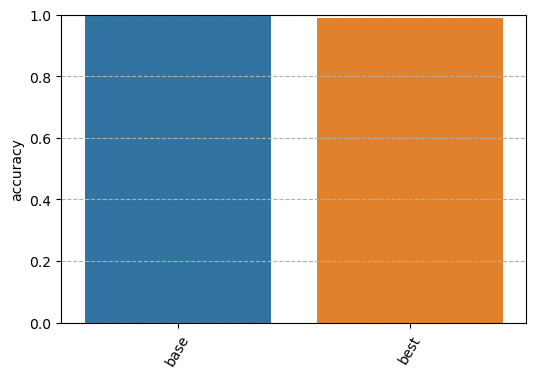

,pipeline,data,accuracy
1,base,test,1.000
2,best,test,0.988


In [72]:
classification_analysis(df_results)

### Base pipeline vs Best pipeline - Classificator performance for train dataset

In [73]:
classificator_performance(pipeline_base, X_train, y_train, target_classes.values())

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00       103
   Chinstrap       1.00      1.00      1.00        54
      Gentoo       1.00      1.00      1.00        92

    accuracy                           1.00       249
   macro avg       1.00      1.00      1.00       249
weighted avg       1.00      1.00      1.00       249



In [74]:
classificator_performance(pipeline_best, X_train, y_train, target_classes.values())

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00       103
   Chinstrap       1.00      1.00      1.00        54
      Gentoo       1.00      1.00      1.00        92

    accuracy                           1.00       249
   macro avg       1.00      1.00      1.00       249
weighted avg       1.00      1.00      1.00       249



### Base pipeline vs Best pipeline - Classificator performance for test dataset

In [75]:
classificator_performance(pipeline_base, X_test, y_test, target_classes.values())

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        43
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        27

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



In [76]:
classificator_performance(pipeline_best, X_test, y_test, target_classes.values())

              precision    recall  f1-score   support

      Adelie       1.00      0.98      0.99        43
   Chinstrap       0.93      1.00      0.97        14
      Gentoo       1.00      1.00      1.00        27

    accuracy                           0.99        84
   macro avg       0.98      0.99      0.98        84
weighted avg       0.99      0.99      0.99        84



### Base pipeline vs Best pipeline - Confusion Matrix, ROC and Recall curve

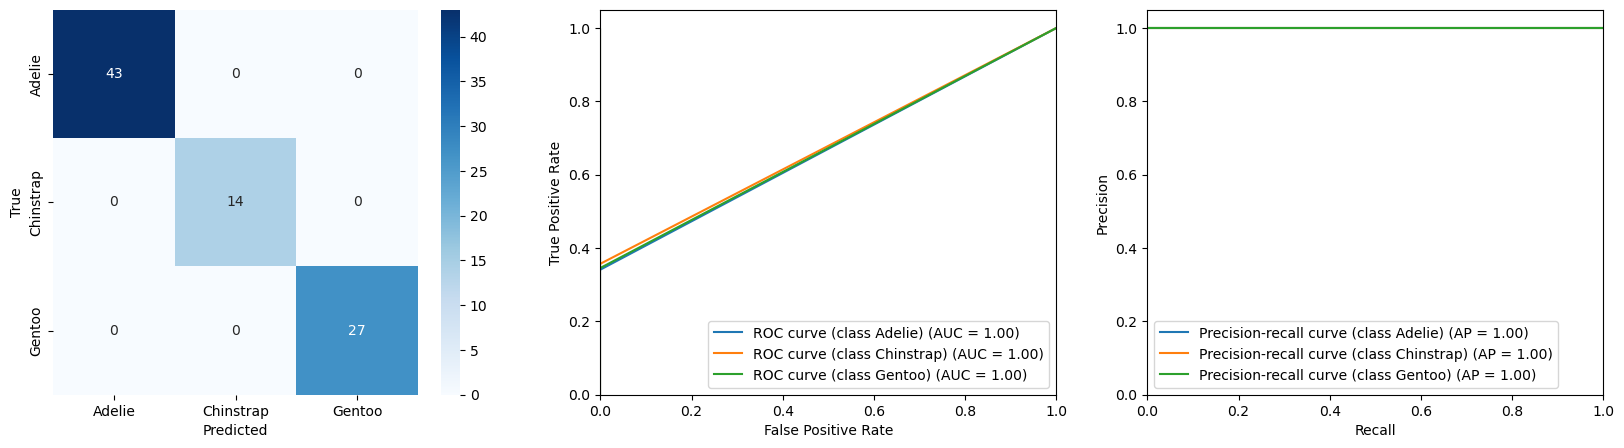

In [77]:
classificator_analysis(model=pipeline_base, X_test=X_test, y_test=y_test, labels_name=target_classes)

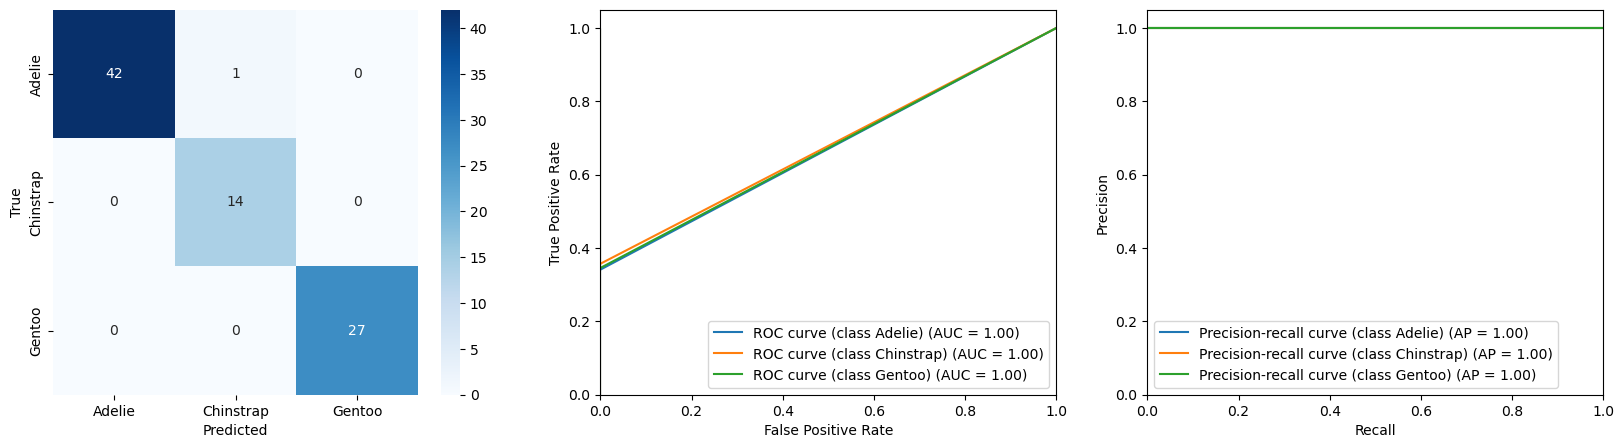

In [78]:
classificator_analysis(model=pipeline_best, X_test=X_test, y_test=y_test, labels_name=target_classes)